In [1]:
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
import pandas as pd
from tqdm import tqdm

import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd
from tensorflow.keras import initializers
from functools import partial
%load_ext autoreload
%autoreload 2
sns.set(style="whitegrid", font_scale=2.25)
# plt.rcParams.update({"text.usetex": True})

try: #If running in colab
    import google.colab
    IN_COLAB = True
    %tensorflow_version 2.x
    #upload vimlts.py first
    import sys
    !wget https://raw.githubusercontent.com/stefan1893/VIMLTS/main/src/vimlts_fast.py
    sys.path.append(".")
    from vimlts_fast import VimltsLinear, ConjungateDenseViGauss
except:
    IN_COLAB = False
    from src.vimlts_fast import VimltsLinear, ConjungateDenseViGauss

We define the prior as a Beta distribution and the coresponding likelihood
is the Bernoulli distribution -> Posterior is a Beta-distribution too.

Likelihood: $$y \thicksim Bernoulli(\pi)$$

Prior: $$ \pi \thicksim  Beta(\alpha, \beta) $$

Posterior: $$p(\pi | y) = \frac{p(y| \pi) \cdot p(\pi)}{p(y)}$$

==> In this case the posterior is known because of the conjugate prior

==> Posterior is a Beta distribution too. Parameters:

$$p(\pi|y) \thicksim Beta(\alpha + \sum{x_i}, \beta+n-\sum{x_i})$$


Prior:
$p(\pi) \thicksim Beta(\alpha=0.5, \beta=5.)$

Text(0.5, 1.0, 'Prior p($\\pi$)')

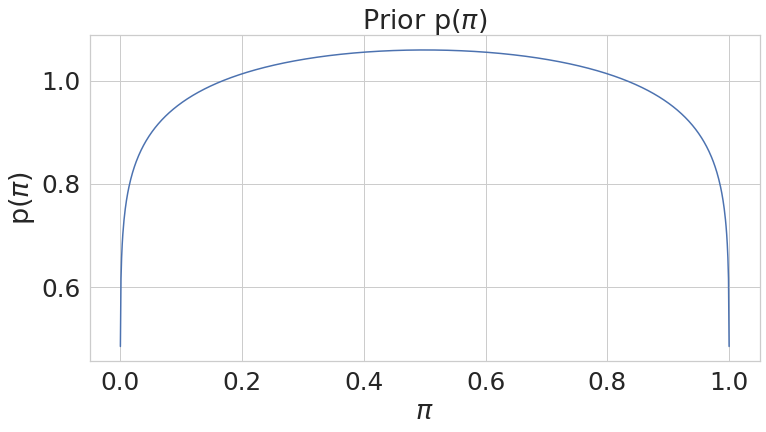

In [2]:
pis = np.linspace(0.0001, .9999, 1000)
alpha = 1.1
beta = 1.1
pdf_prior = stats.beta(a=alpha, b=beta).pdf(x=pis)
plt.figure(figsize=(12,6))
sns.lineplot(data=pd.DataFrame.from_dict({'p($\pi$)':pdf_prior, '$\pi$':pis}), x='$\pi$', y='p($\pi$)')
plt.title("Prior p($\pi$)")

Likelihood

(array([0., 0., 0., 0., 0., 2., 0., 0., 0., 0.]),
 array([0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5]),
 <BarContainer object of 10 artists>)

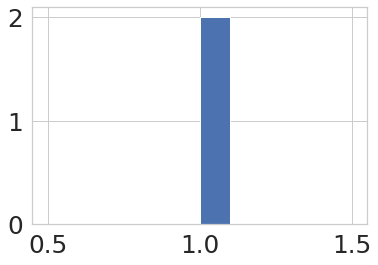

In [3]:
np.random.seed(3)
data = stats.bernoulli(p=0.5).rvs(size=2)
ytensor = data.reshape(-1, 1)
plt.hist(data)

Text(0.5, 1.0, 'Likelihood p(y|$\\pi$)')

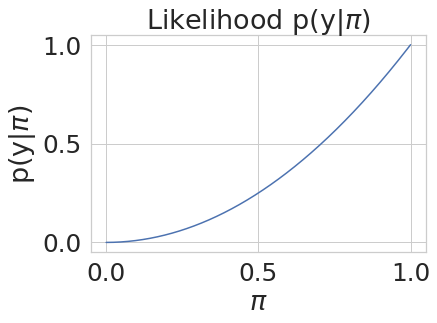

In [4]:
log_likelihood = [stats.bernoulli(p=pi).logpmf(data).sum() for pi in pis]
likelihood = np.exp(log_likelihood)
sns.lineplot(data=pd.DataFrame.from_dict({'p(y|$\pi$)':likelihood, '$\pi$':pis}), x='$\pi$', y='p(y|$\pi$)')
plt.title("Likelihood p(y|$\pi$)")

Posterior analytic

$$p(\pi|y) \thicksim Beta(\alpha + \sum{x_i}, \beta+n-\sum{x_i})$$

integral of pdf:  0.9997861466738089


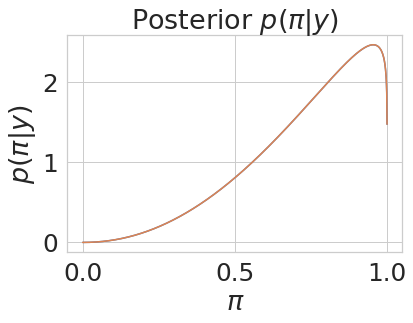

In [5]:
alpha_post = alpha + np.sum(data)
beta_post = beta + len(data) - np.sum(data)
pdf_post = stats.beta(a=alpha_post, b=beta_post).pdf(x=pis)
sns.lineplot(data=pd.DataFrame.from_dict({'$p(\pi|y)$':pdf_post, '$\pi$':pis}), x='$\pi$', y='$p(\pi|y)$')
plt.plot(pis, likelihood*pdf_prior/np.trapz(likelihood*pdf_prior, pis), linestyle='solid')
plt.title("Posterior $p(\pi|y)$")
print("integral of pdf: ", np.trapz(pdf_post, pis))

like * prior same as analytic known posterior distribution

Now use VIMLTs to approximate posterior distribution


## TM-VI vs Gauss-VI


In [6]:
def scheduler(epoch, lr, lr_start, lr_stop, epochs):
    return lr_start + (lr_stop-lr_start)*(epoch/epochs)

@tf.function
def sample_bernoulli_nll(y_obs, y_pred):
    """
    Args:
        y_obs: true labels. Expected shape (#batch, 1) or (#batch)
        y_pred: model prediction. Expected shape (#samples, #batch, 1) or (#samples, #batch)

    Returns: sum of Nll
    """
    if len(y_pred.shape) == 2:  # Bug tf?! If we have a single output it squeezes y_pred. I did not want this behaviour.
        y_pred = y_pred[...,None]
    tf.debugging.check_numerics(y_pred, "Prediction for nll computation contains NaNs or Infs")
    error_str = f"Expected one of the above defined shapes. Got shapes: y_obs: {y_obs.shape}; y_pred: {y_pred.shape}"
    assert y_pred.shape[-1] == y_obs.shape[-1] or ((len(y_pred.shape) == 3) and y_pred.shape[-1] == 1), error_str

    dist = tfp.distributions.Bernoulli(probs=y_pred)
    nll_per_sample = -dist.log_prob(y_obs)
    nlls = tf.reduce_mean(nll_per_sample, axis=0)
    tf.debugging.check_numerics(nlls, "NLL contains NaNs or Infs")
    return tf.reduce_sum(nlls)
    # return 0.

def softplus_inv(y):
    return np.log(np.exp(y) - 1)

### initialize TM-VI

In [7]:
models = {}
Ms = [1,10,30]
for M in Ms:
    # init params
    kernel_initializers=dict(kernel_init_alpha_w = initializers.RandomNormal(mean=1.5),
                             kernel_init_beta_w = initializers.RandomNormal(),
                             kernel_init_alpha_z = initializers.RandomNormal(mean=1),
                             kernel_init_beta_z = initializers.RandomNormal(),
                             kernel_init_thetas = [initializers.RandomNormal(mean=-1.5, stddev=.3)] + [initializers.RandomNormal(mean=softplus_inv((2+1.5)/M), stddev=.5) for i in range(M)])
    # define model
    tf.random.set_seed(2)
    layer = VimltsLinear(1,
                         activation=tfp.bijectors.Sigmoid(low=1e-6, high=1.-1e-6),
                         **kernel_initializers,
                         num_samples=10000,
                         prior_dist=tfd.Beta(concentration1=alpha, concentration0=beta),
                         input_shape=(1,),)
    model = tf.keras.Sequential([layer], name=f"TM-VI-degree{M}")
    model.build(input_shape=(None, 1))
    models[f"TM-VI M={M}"] = model
model.summary()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model: "TM-VI-degree30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vimlts_linear_2 (VimltsLinea (10000, None, 1)          35        
Total params: 35
Trainable params: 35
Non-trainable params: 0
_________________________________________________________________


### initialize VI Gauss implementation

In [8]:
tf.random.set_seed(2)
vi_gauss_l = ConjungateDenseViGauss(1,
                                   activation=tfp.bijectors.Sigmoid(low=1e-6, high=1.-1e-6),
                                   num_samples=10000,
                                   kernel_init_mu_w = initializers.Constant(0.),
                                   kernel_init_rhosigma_w = initializers.Constant(0.2),
                                   prior_dist=tfd.Beta(concentration1=alpha, concentration0=beta))
vi_gauss = tf.keras.Sequential([vi_gauss_l], name="Gauss-VI")
vi_gauss.build(input_shape=(None,1))
vi_gauss.summary()
models["Gauss-VI"] = vi_gauss

Model: "Gauss-VI"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conjungate_dense_vi_gauss (C (10000, None, 1)          2         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


### show initial distribution

VI Gaus with: N(<tf.Variable 'conjungate_dense_vi_gauss/kernel_mu:0' shape=(1, 1) dtype=float32, numpy=array([[0.]], dtype=float32)>,[[0.79813886]])


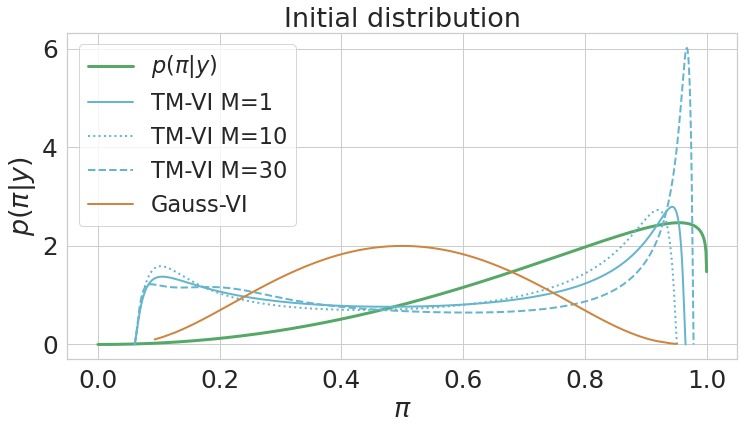

In [9]:
plt.figure(figsize=(12,6))
pdf_post = stats.beta(a=alpha_post, b=beta_post).pdf(x=pis)
sns.lineplot(data=pd.DataFrame.from_dict({'$p(\pi|y)$':pdf_post, '$\pi$':pis}), x='$\pi$', y='$p(\pi|y)$', label='$p(\pi|y)$', linewidth=3, color='g')
linestyles = ['-', ':', '--', '-.']
ls = 0
for name, model in models.items():
    layer = model.layers[0]
    qw, w = layer.get_w_dist()
    bij = tfp.bijectors.Sigmoid()
    pi = bij(w)
    log_q_pi = tf.math.log(qw) - bij.forward_log_det_jacobian(w, event_ndims=0)
    q_pi = tf.math.exp(log_q_pi)
    if "TM-VI" in name:
        plt.plot(pi, q_pi, label=name, linewidth=2., color='c', linestyle=linestyles[ls])
        ls += 1
    else:
        plt.plot(pi, q_pi, label=name, linewidth=2., color='peru')
plt.legend(fontsize='small')
plt.title("Initial distribution")
plt.savefig("00_initial_variational_distribution_VIMLTS.png")


### train

In [10]:
class LogKL(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['epochs'] = epoch
        # kl = [layer.losses[0] for layer in self.model.layers]
        # # logs['kl'] = tf.reduce_sum(kl)
        # logs['kl'] = kl

for name, model in models.items():
    print(f"Start experiment with model {name}")
    epochs = 10000
    lr_callback = tf.keras.callbacks.LearningRateScheduler(partial(scheduler, lr_start=0.05, lr_stop=0.025, epochs=epochs))
    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.05), loss=sample_bernoulli_nll, run_eagerly=False)
    model.fit(tf.ones((len(data),1)), ytensor, epochs=epochs, verbose=False, callbacks=[lr_callback, LogKL()])

Start experiment with model TM-VI M=1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Start experiment with model TM-VI M=10
Start experiment with model TM-VI M=30
Start experiment with model Gauss-VI


### Show posterior distribution of VIMLT and VI Gaussian and compute KL-Divergence
#### Table shows the KL-Divergence $D_{KL} (q_w(\pi) || p(\pi|D)$

VI Gaus with: N(<tf.Variable 'conjungate_dense_vi_gauss/kernel_mu:0' shape=(1, 1) dtype=float32, numpy=array([[1.3379198]], dtype=float32)>,[[1.244579]])
Table shows the KL divergence KL(q(pi)||p(pi|D))


,KL
Gauss-VI,0.022184
TM-VI M=1,0.007297
TM-VI M=10,0.000987
TM-VI M=30,0.000813


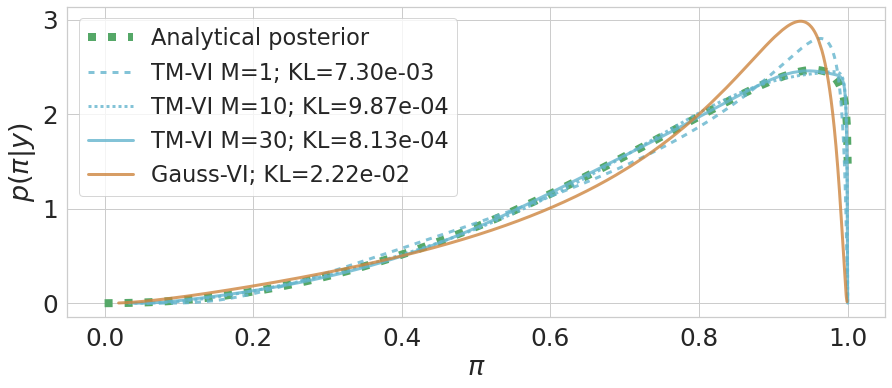

In [11]:
alpha_post = alpha + np.sum(data)
beta_post = beta + len(data) - np.sum(data)
post_analytic = tfd.Beta(alpha_post.astype(np.float32), beta_post.astype(np.float32))
plt.figure(figsize=(13,6))
sns.lineplot(data=pd.DataFrame.from_dict({'$p(\pi|y)$':post_analytic.prob(pis), '$\pi$':pis}), x='$\pi$', y='$p(\pi|y)$', label="Analytical posterior", linewidth=8, color='g', linestyle=(0, (1, 1.5)))
KLs = {}
linestyles = [(0, (2, 2)), (0, (1, 1)), '-']
ls = 0
for name, model in models.items():
    layer = model.layers[0]
    qw, w = layer.get_w_dist(num=100000)
    bij = tfp.bijectors.Sigmoid()
    pi = bij(w)
    log_q_pi = tf.math.log(qw) - bij.forward_log_det_jacobian(w, event_ndims=0)
    q_pi = tf.math.exp(log_q_pi)

    # compute KL div KL(q(pi) || p(pi|D))
    log_p_pi_D = post_analytic.log_prob(pi)
    rel_entropy = q_pi * (log_q_pi - log_p_pi_D)
    kl_div = np.trapz(rel_entropy, x=pi)
    KLs[name] = kl_div

    if "TM-VI" in name:
        plt.plot(pi, q_pi, label=name+f"; KL={kl_div:.2e}", linewidth=3., color='c', linestyle=linestyles[ls], alpha=0.8)
        ls += 1
    else:
        plt.plot(pi, q_pi, label=name+f"; KL={kl_div:.2e}", linewidth=3., color='peru', alpha=0.8)

plt.legend(fontsize='small')
# plt.title("Posterior distribution")
plt.tight_layout()
plt.savefig("00_conj_posterior.pdf")

print("Table shows the KL divergence KL(q(pi)||p(pi|D))")
pd.DataFrame.from_dict(KLs, orient='index', columns=["KL"]).sort_values('KL', ascending=False)

### Show loss curve

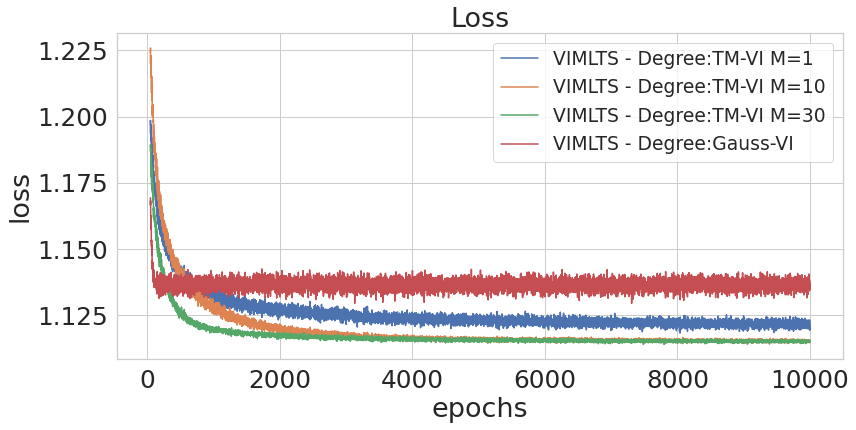

In [12]:
plt.figure(figsize=(13,6))
for m, model in models.items():
    plt.plot(model.history.history['epochs'][50:], model.history.history['loss'][50:], label=f"VIMLTS - Degree:{m}")
plt.title("Loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(fontsize='x-small')
plt.savefig("00_conj_prior_loss.png")

### Analyse init parameters

In [13]:
thetas = dict()
for M in range(2,15,4):
    delta_start = -6
    def softplus_inv(y):
        return np.log(np.exp(y) - 1)
    delta_theta_init = (delta_start,) + tuple(softplus_inv((2-delta_start)/(M-1)) for _ in range(M-1))

    theta_p = tf.cast(tf.reshape(delta_theta_init, (1,-1)), tf.float32) # [#input x #output x M]
    theta_p = tf.concat((theta_p[..., 0:1], tf.math.softplus(theta_p[..., 1:])), axis=-1)
    n = theta_p.shape[-1]
    # tf.ones((n * (n + 1) // 2))
    m_triangle = tfp.math.fill_triangular(tf.ones(n * (n + 1) // 2), upper=True)
    theta = theta_p @ m_triangle

    thetas[f"theta_degree{M}"] = [delta_theta_init, theta.numpy().squeeze()]

Text(0.5, 0, 'i')

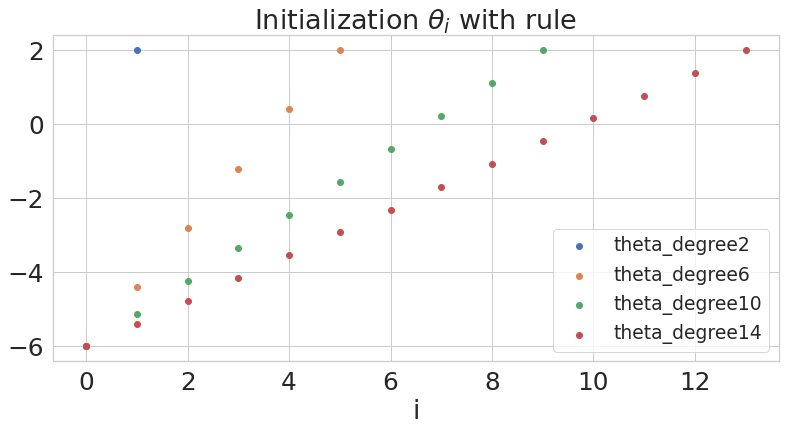

In [14]:
plt.figure(figsize=(13,6))
for name, (delta_theta, theta) in thetas.items():
    plt.scatter(range(len(theta)), theta, label=name)
plt.legend(fontsize='x-small')
plt.title("Initialization $\\theta_i$ with rule")
plt.xlabel("i")

Text(0.5, 0, 'i')

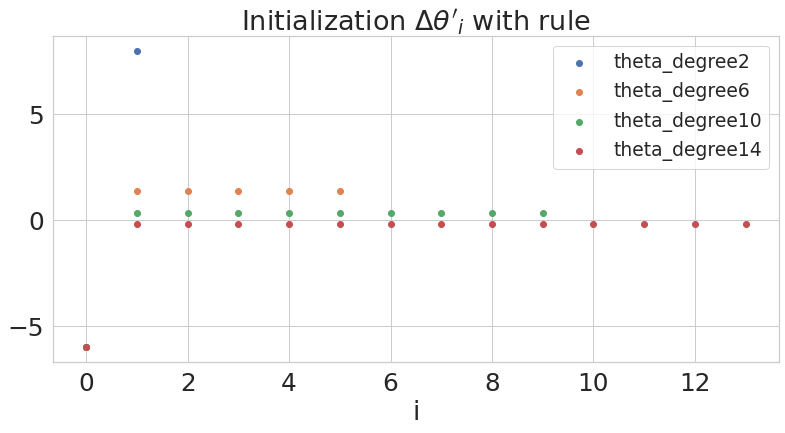

In [15]:
plt.figure(figsize=(13,6))
for name, (delta_theta, theta) in thetas.items():
    plt.scatter(range(len(delta_theta)), delta_theta, label=name)
plt.legend(fontsize='x-small')
plt.title("Initialization $\Delta\\theta'_i$ with rule")
plt.xlabel("i")

